# Vaccination Strategies Analysis on Temporal Contact Networks

**Author:** Marcus Vinícius Santos Rodrigues - 11218862

**Description:** Simulation and comparison of vaccination strategies using real-world RFID contact networks (office, primary school, high school, hospital).

---


# 1. Introduction

This notebook investigates the impact of different vaccination strategies on epidemic spreading over real-world temporal contact networks. Using the SIR (Susceptible-Infected-Recovered) epidemiological model, we simulate disease transmission on four public RFID-based proximity datasets: an office, a primary school, a high school, and a hospital ward.

The study explores how various immunization approaches — such as targeting highly connected individuals or using random selection — affect the final outbreak size. Centrality-based vaccination strategies leverage topological features of the network, including node degree, k-core index, betweenness centrality, and eigenvector centrality. The results are compared with a baseline of random vaccination.

The primary goals of this study are as follows:

- To implement epidemic spreading models, particularly the Susceptible-Infected-Recovered (SIR) model, on real-world temporal contact networks.
- To compute the final epidemic size, measured as the fraction of individuals in the Recovered compartment at the end of the simulation ($R(\infty)/N$).
- To analyze the impact of vaccination by simulating the SIR model under different immunization strategies.
- To systematically vaccinate individuals based on various network centrality measures — specifically, degree, k-core, betweenness, and eigenvector centralities — and assess their effectiveness in reducing the final epidemic size.
- To compare these targeted vaccination strategies with random vaccination as a baseline.

The SIR model, in this context, follows the classical compartmentalization:

- **S(t)**: Number of *Susceptible* individuals at time t.
- **I(t)**: Number of *Infected* individuals at time t.
- **R(t)**: Number of *Recovered* (and immune) individuals at time t.

Transitions occur as follows:
- Each susceptible individual in contact with an infected individual has a probability τ (tau) per time step to become infected.
- Each infected individual has a probability γ (gamma) per time step to recover and become immune.

The model is applied over temporally-resolved contact networks, reflecting the dynamic nature of human interactions.

# 2. Libraries and Configuration

This section imports all Python libraries required for data processing, network analysis, statistical inference, and visualization. The main libraries used include:

- **pandas** and **numpy** for data manipulation and numerical computing.
- **networkx** for constructing and analyzing graphs.
- **matplotlib** and **seaborn** for data visualization.
- **scipy.stats** for statistical tests and confidence intervals.
- **tqdm** for progress bars in simulation loops.
- **warnings** and **os** for suppressing unnecessary messages and handling file paths.

Visualization preferences are set for consistency throughout the notebook.

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import t, f_oneway, kruskal, ttest_ind, mannwhitneyu
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")

# 3. Data Loading and Initial Exploration

The four real-world contact datasets (office, primary school, high school, hospital) are loaded into memory. Each dataset contains temporally resolved proximity events between pairs of individuals, captured via RFID sensors.

Summary statistics are computed and displayed for each dataset, including:

- Number of contact events (edges in the temporal network).
- Number of unique individuals (nodes).
- Temporal coverage (start and end times, total duration).
- Number of unique timestamps (granularity of temporal sampling).

These statistics help contextualize the differences in network structure and temporal resolution among datasets.

In [8]:
# Loaders for each dataset
def load_primary_school(path_data, path_meta):
    # Reads the primary school contact data and metadata from tab-separated files
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_high_school(path_data, path_meta):
    # Reads the high school contact data and metadata from tab-separated files
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_office(path_data, path_meta):
    # Reads the office contact data and metadata from tab-separated files
    df = pd.read_csv(path_data, sep='\t', engine='python')
    meta = pd.read_csv(path_meta, sep='\t', engine='python')
    return df, meta

def load_hospital(path_data):
    # Reads the hospital contact data from a tab-separated file (no metadata)
    df = pd.read_csv(path_data, sep='\t', engine='python')
    return df

In [9]:
# Office
df_office, meta_office = load_office('datasets/office/office.csv',
                                     'datasets/office/metadata_office.csv')

# Hospital
df_hospital = load_hospital('datasets/hospital/hospital.csv')

# Primary School
df_primary, meta_primary = load_primary_school('datasets/primary_school/primary_school.csv',
                                              'datasets/primary_school/metadata_primary_school.csv')

# High School
df_high, meta_high = load_high_school('datasets/high_school/high_school.csv',
                                      'datasets/high_school/metadata_high_school.csv')

# 4. Network Construction and Preprocessing

This section aggregates temporal contact events into static (time-aggregated) networks. Each edge weight corresponds to the total number of contacts between two individuals across the observation period.

For each dataset, the following network properties are computed and visualized:

- Number of nodes and edges.
- Connectivity status (whether the network is connected).
- Number of connected components.
- Size of the largest connected component.

The largest connected component of each aggregated network is visualized using a force-directed layout. Understanding these properties is essential for interpreting the impact of network structure on epidemic spreading.

**Mathematical Notes:**

- The *degree* ( $k_i$ ) of a node ( $i$ ) is the number of unique neighbors it has.
- The *adjacency matrix* ( $A$ ) represents edges: ( $A_{ij}$ = 1 ) if there is an edge between ( $i$ ) and ( $j$ ).

In [10]:
def aggregate_contacts(df, remove_selfloops=True):
    """
    Aggregates temporal contact data into a static weighted graph.

    Groups all contact events between each pair of nodes and creates an undirected graph,
    where edge weights represent the total number of contacts between each node pair.

    Args:
        df (pd.DataFrame): DataFrame containing at least 'id1' and 'id2' columns for node identifiers.
        remove_selfloops (bool, optional): If True, removes self-loop edges (edges where id1 == id2). Default is True.

    Returns:
        networkx.Graph: Undirected weighted graph where each edge weight equals the total number of contacts.
    """
    # Group by node pairs and count the number of contacts (edge weight)
    edges = df.groupby(['id1', 'id2']).size().reset_index(name='weight')
    if remove_selfloops:
        # Optionally remove self-loops (edges from a node to itself)
        edges = edges[edges['id1'] != edges['id2']]
    # Create an undirected graph with edge weights
    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(int(row['id1']), int(row['id2']), weight=int(row['weight']))
    return G

In [11]:
# Usage:
# Given contact dataframes for each dataset, aggregate them into graphs
G_primary = aggregate_contacts(df_primary)   # Primary School graph
G_high = aggregate_contacts(df_high)         # High School graph
G_office = aggregate_contacts(df_office)     # Office graph
G_hospital = aggregate_contacts(df_hospital) # Hospital graph

# 5. Centrality Measures Calculation

Vaccination strategies are defined based on various node centrality measures, which quantify structural importance in the network. For each aggregated network, the following centralities are computed:

- **Degree centrality**: $( C_{\text{degree}}(i) = \frac{k_i}{N-1} )$
  - Measures the number of direct connections for node $( i )$.

- **k-core index (coreness)**: The highest $( k )$ such that node $( i )$ belongs to a $( k )$-core (a maximal subgraph where all nodes have degree at least $( k )$).

- **Betweenness centrality**: 
  $$
  C_{\text{betw}}(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}
  $$
  where $( \sigma_{st} )$ is the number of shortest paths from node $( s )$ to node $( t )$, and $( \sigma_{st}(i) )$ is the number passing through $( i )$.

- **Eigenvector centrality**: 
  $$
  x_i = \frac{1}{\lambda} \sum_{j} A_{ij} x_j
  $$
  The centrality vector $( x )$ is the leading eigenvector of the adjacency matrix.

Nodes are ranked by these scores to determine vaccination targets under each strategy.



Graph Primary School
Number of nodes: 242
Number of edges: 8317
Is connected? True
Number of connected components: 1
Size of the largest connected component: 242


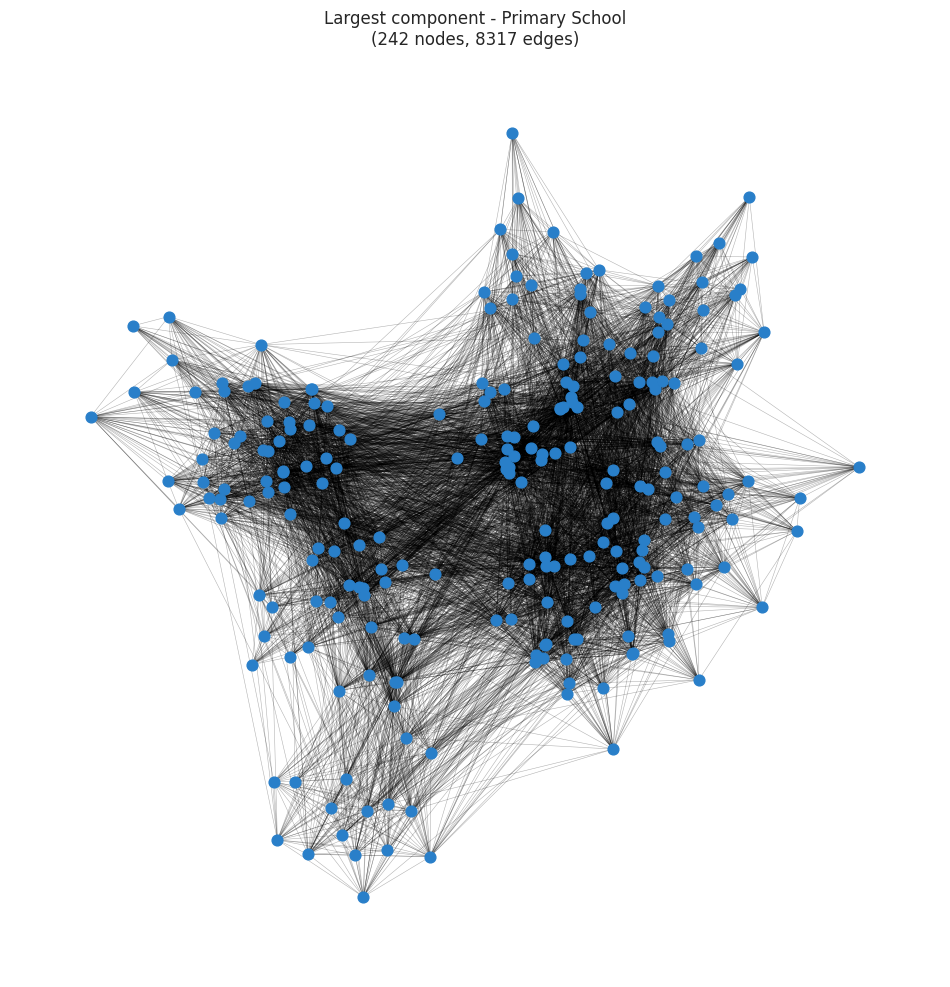


Graph High School
Number of nodes: 327
Number of edges: 5818
Is connected? True
Number of connected components: 1
Size of the largest connected component: 327


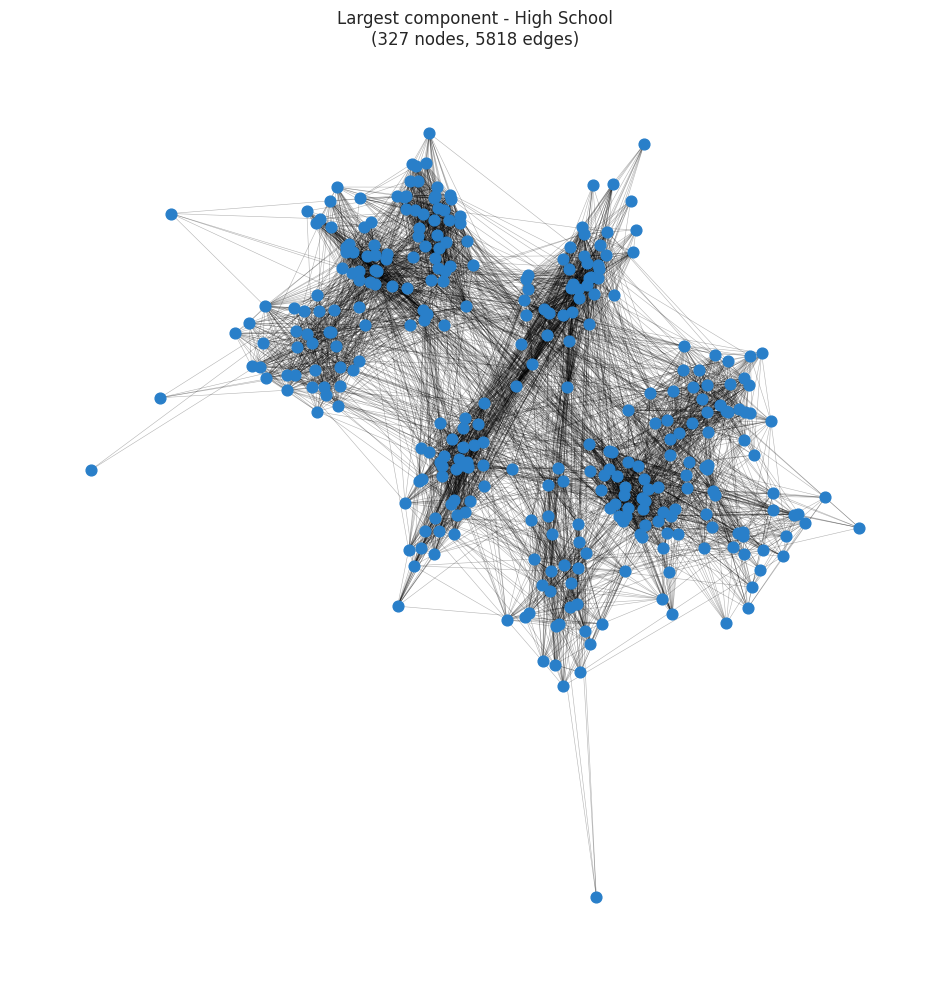


Graph Office
Number of nodes: 92
Number of edges: 755
Is connected? True
Number of connected components: 1
Size of the largest connected component: 92


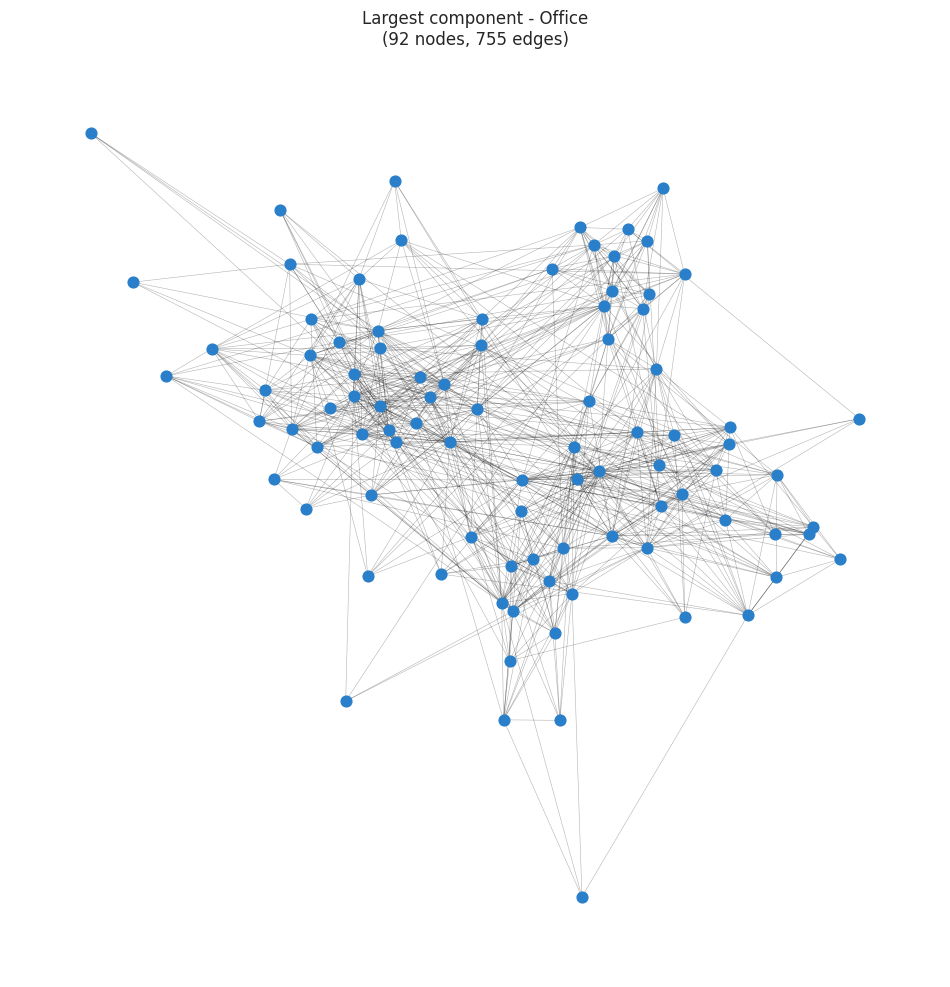


Graph Hospital
Number of nodes: 75
Number of edges: 1139
Is connected? True
Number of connected components: 1
Size of the largest connected component: 75


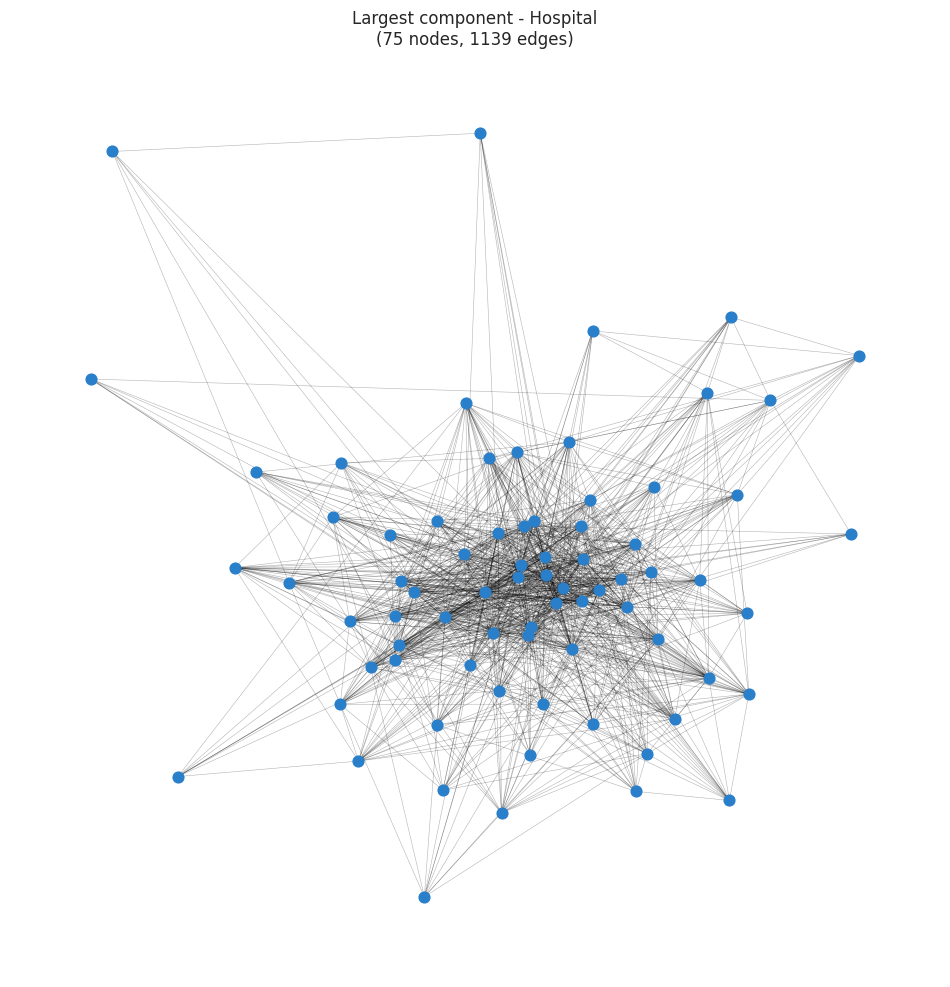

In [12]:
# Dataset names and preloaded graphs
datasets = {
    "Primary School": G_primary,
    "High School": G_high,
    "Office": G_office,
    "Hospital": G_hospital
}

for name, G in datasets.items():
    print(f"\nGraph {name}")
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
        connected = nx.is_connected(G)
        print("Is connected?", connected)
        n_comp = nx.number_connected_components(G)
        print("Number of connected components:", n_comp)
        components = sorted(nx.connected_components(G), key=len, reverse=True)
        biggest_size = len(components[0]) if components else 0
        print("Size of the largest connected component:", biggest_size)
        
        # Visualization: largest component
        plt.figure(figsize=(12, 12))
        subG = G.subgraph(components[0])
        pos = nx.spring_layout(subG, seed=42)
        # Draw edges with low alpha
        nx.draw_networkx_edges(subG, pos, edge_color='#000', alpha=0.3, width=0.4)

        # Draw nodes with full opacity
        nx.draw_networkx_nodes(subG, pos, node_size=60, node_color='#297fc9', alpha=1.0)
        plt.title(f"Largest component - {name}\n({biggest_size} nodes, {subG.number_of_edges()} edges)")
        plt.axis('off')
        plt.show()
    else:
        print("The graph is empty!")
        # Symbolic visualization for an empty graph
        plt.figure(figsize=(3, 3))
        plt.text(0.5, 0.5, "Empty", fontsize=18, ha='center')
        plt.title(name)
        plt.axis('off')
        plt.show()

In [13]:
def compute_centralities(G):
    centralities = {
        'degree': nx.degree_centrality(G),
        'kcore': nx.core_number(G),
        'betweenness': nx.betweenness_centrality(G, k=min(200, len(G)), seed=42),
        'eigencentrality': nx.eigenvector_centrality_numpy(G)
    }
    return centralities

centralities_primary = compute_centralities(G_primary)
centralities_high = compute_centralities(G_high)
centralities_office = compute_centralities(G_office)
centralities_hospital = compute_centralities(G_hospital)

In [14]:
temporal_datasets = {
    "Primary School": df_primary,
    "High School": df_high,
    "Office": df_office,
    "Hospital": df_hospital
}

for name, df in temporal_datasets.items():
    timestamps = df['timestamp']
    min_time = timestamps.min()
    max_time = timestamps.max()
    n_events = len(timestamps)
    n_times = len(np.unique(timestamps))
    print(f"{name}:")
    print(f"  - First timestamp: {min_time}")
    print(f"  - Last timestamp:   {max_time}")
    print(f"  - Interval (max - min): {max_time - min_time}")
    print(f"  - Number of events (rows): {n_events}")
    print(f"  - Number of unique timestamps: {n_times}")
    print()

Primary School:
  - First timestamp: 31220
  - Last timestamp:   148120
  - Interval (max - min): 116900
  - Number of events (rows): 125773
  - Number of unique timestamps: 3100

High School:
  - First timestamp: 1385982020
  - Last timestamp:   1386345580
  - Interval (max - min): 363560
  - Number of events (rows): 188508
  - Number of unique timestamps: 7375

Office:
  - First timestamp: 28820
  - Last timestamp:   1016440
  - Interval (max - min): 987620
  - Number of events (rows): 9827
  - Number of unique timestamps: 7104

Hospital:
  - First timestamp: 140
  - Last timestamp:   347640
  - Interval (max - min): 347500
  - Number of events (rows): 32424
  - Number of unique timestamps: 9453



# 6. Vaccination Strategies

This section defines algorithms to select individuals for vaccination according to different strategies:

- **Random**: Randomly choose a fraction $( f )$ of all nodes for vaccination.
- **Degree-based**: Select nodes with the highest degree centrality.
- **k-core**: Select nodes with the highest k-core index.
- **Betweenness**: Select nodes with the highest betweenness centrality.
- **Eigenvector**: Select nodes with the highest eigenvector centrality.

Given a strategy and a fraction $( f )$, the top $( \lceil fN \rceil )$ nodes are chosen as vaccinated, where $( N )$ is the total number of nodes. These nodes are set as immune (in the Recovered state) at the start of each simulation.

In [15]:
def select_vaccinated(G, centrality_dict, fraction, strategy='degree'):
    """
    Choose a fraction of nodes to vaccinate, according to a given strategy.
    
    Args:
        G: networkx.Graph (aggregated or largest component)
        centrality_dict: dictionary of node centrality scores (by strategy)
        fraction: float [0,1] = fraction of nodes to vaccinate
        strategy: one of 'random', 'degree', 'kcore', 'betweenness', 'eigencentrality'
    
    Returns:
        vaccinated: set of node IDs
    """
    n_vaccinated = int(fraction * len(G))
    n_vaccinated = max(1, n_vaccinated)
    if strategy == 'random':
        return set(random.sample(list(G.nodes()), n_vaccinated))
    else:
        ranking = sorted(centrality_dict[strategy].items(), key=lambda x: x[1], reverse=True)
        return set([node for node, _ in ranking[:n_vaccinated]])

# 7. SIR Model Simulation (Time-Windowed)

Epidemic simulations use a discrete-time SIR (Susceptible-Infected-Recovered) model, adapted to dynamic temporal networks. At each time window ("tick"), only contacts present during that window are considered for possible transmission.

**SIR Dynamics:**
- At time $( t )$, each infected node may transmit the disease to susceptible neighbors with probability $( \tau )$ per contact.
- Each infected node independently recovers with probability $( \gamma )$ per tick.

**Algorithm Steps:**
1. Partition contact events into consecutive time windows of fixed duration (tick size).
2. At each tick:
   - Construct the instantaneous contact network from contacts in that window.
   - For each S-I pair in contact, the susceptible becomes infected with probability $( \tau )$.
   - Each infected node recovers with probability $( \gamma )$.
3. Vaccinated nodes are initialized as Recovered (immune).
4. Simulations are repeated multiple times to account for stochasticity.

The outcome of interest is the final fraction of the population that is infected during the outbreak (i.e., the total Recovered at the end).


In [16]:
def run_SIR_timewindow(
    tick_dict, 
    node_set,
    tau=0.1, 
    gamma=0.1, 
    n_ticks=None, 
    vaccinated_nodes=set(), 
    initial_infected=None, 
    rng=None
):
    """
    Simulate SIR dynamics over time windows, updating the network at each tick.
    
    Args:
        tick_dict: dict {tick_index: [(u, v), ...]}, one per time window
        node_set: set of all individual IDs (nodes in the network)
        tau: infection probability per contact per tick
        gamma: recovery probability per infected per tick
        n_ticks: number of ticks to simulate (default: full data range)
        vaccinated_nodes: set of nodes who start immune (in 'Recovered')
        initial_infected: set or list of initial infected (if None, randomly pick one)
        rng: numpy random generator (optional, for reproducibility)
    
    Returns:
        history: list of dicts, with S/I/R counts for each tick
    """
    if rng is None:
        rng = np.random.default_rng()
    
    all_nodes = set(node_set)
    susceptible = set(all_nodes) - set(vaccinated_nodes)
    if initial_infected is None:
        initial_infected = {rng.choice(list(susceptible))}
    infected = set(initial_infected)
    susceptible -= infected
    recovered = set(vaccinated_nodes)

    history = []
    ticks = sorted(tick_dict.keys())
    if n_ticks is None:
        n_ticks = ticks[-1] + 1 if ticks else 0

    for tick in range(n_ticks):
        contacts = tick_dict.get(tick, [])
        # Build the contact graph for this tick
        G_tick = nx.Graph()
        G_tick.add_edges_from(contacts)
        new_infected = set()
        
        # Only active edges at this time can propagate infection
        for u, v in contacts:
            if (u in infected and v in susceptible):
                if rng.random() < tau:
                    new_infected.add(v)
            elif (v in infected and u in susceptible):
                if rng.random() < tau:
                    new_infected.add(u)
        
        # Update infection state
        susceptible -= new_infected
        infected |= new_infected

        # Each infected may recover independently (gamma per tick)
        new_recovered = set()
        for node in list(infected):
            if rng.random() < gamma:
                infected.remove(node)
                recovered.add(node)
                new_recovered.add(node)
        
        # Record S/I/R counts for this tick
        history.append({'S': len(susceptible), 'I': len(infected), 'R': len(recovered)})

        # Stop early if epidemic dies out
        if not infected:
            # Pad rest of ticks with same counts
            for _ in range(tick + 1, n_ticks):
                history.append({'S': len(susceptible), 'I': 0, 'R': len(recovered)})
            break

    return history

def repeat_SIR_timewindow(
    df_contacts,
    node_set,
    tau=0.1,
    gamma=0.1,
    vaccinated_nodes=set(),
    tick_size=60,
    n_runs=30,
    initial_infected=None,
    seed=42
):
    """
    Repeat the SIR time-window simulation multiple times to get statistics.
    
    Args:
        df_contacts: DataFrame of temporal contacts
        node_set: set of all node IDs
        tau: infection probability
        gamma: recovery probability
        vaccinated_nodes: set of initially immune nodes
        tick_size: size of each time window
        n_runs: how many independent simulation runs
        initial_infected: optionally, set/list of nodes to always use as seeds
        seed: base random seed
    
    Returns:
        mean: mean S/I/R counts at each tick (shape: [n_ticks, 3])
        std:  stddev S/I/R counts at each tick (shape: [n_ticks, 3])
        arr:  all runs, shape [n_runs, n_ticks, 3]
    """
    tick_dict, min_time = split_contacts_by_tick(df_contacts, tick_size)
    n_ticks = max(tick_dict.keys()) + 1 if tick_dict else 0

    all_histories = []
    rng = np.random.default_rng(seed)
    for i in range(n_runs):
        # Use a different seed per run for independence
        this_seed = rng.integers(0, 1e9)
        history = run_SIR_timewindow(
            tick_dict,
            node_set,
            tau=tau,
            gamma=gamma,
            n_ticks=n_ticks,
            vaccinated_nodes=vaccinated_nodes,
            initial_infected=initial_infected,
            rng=np.random.default_rng(this_seed)
        )
        all_histories.append(history)

    # Align all histories to the same length (pad with last value)
    maxlen = max(len(h) for h in all_histories)
    for h in all_histories:
        while len(h) < maxlen:
            h.append(h[-1])
    arr = np.array([ [ [x['S'], x['I'], x['R']] for x in h ] for h in all_histories ])
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    return mean, std, arr

def split_contacts_by_tick(df_contacts, tick_size=60):
    """
    Split a DataFrame of temporal contacts into a dictionary of time windows (ticks).

    Only uses ['timestamp', 'id1', 'id2'], even if extra columns are present.

    Args:
        df_contacts: DataFrame with at least columns ['timestamp', 'id1', 'id2']
        tick_size: window size in seconds (e.g., 60 for 1-min ticks)
    
    Returns:
        tick_dict: dict mapping tick_index -> list of (id1, id2) contacts
        min_time: first timestamp in the data
    """
    # Make sure to use only timestamp, id1, id2
    df = df_contacts[['timestamp', 'id1', 'id2']].copy()
    min_time = df['timestamp'].min()
    df['tick'] = ((df['timestamp'] - min_time) // tick_size).astype(int)
    tick_dict = df.groupby('tick')[['id1', 'id2']].apply(lambda x: list(map(tuple, x.values))).to_dict()
    return tick_dict, min_time

## 8. Simulation Execution and Summary Statistics

For each combination of dataset, infection probability ($\tau$), vaccination coverage fraction, and vaccination strategy, epidemic simulations are executed multiple times to obtain robust statistics.

Key summary statistics are computed for the final epidemic size ($R(\infty) / N$), where:
- $R(\infty)$ = number of individuals who have recovered at the end of the outbreak,
- $N$ = total number of individuals.

The following metrics are reported:
- Mean and standard deviation of final epidemic size.
- Median, first and third quartiles (Q1, Q3), and interquartile range (IQR).
- 95% confidence interval for the mean, using Student's t-distribution:
  $$
  \text{CI}_{95\%} = \left[ \bar{x} - t_{0.975, n-1} \frac{s}{\sqrt{n}},\ \bar{x} + t_{0.975, n-1} \frac{s}{\sqrt{n}} \right]
  $$
  where $\bar{x}$ is the sample mean, $s$ is the sample standard deviation, and $n$ is the number of runs.


In [17]:
# Organize the graphs and centralities in a dict
datasets = {
    "Primary School": (G_primary, centralities_primary),
    "High School": (G_high, centralities_high),
    "Office": (G_office, centralities_office),
    "Hospital": (G_hospital, centralities_hospital)
}

# Define simulation parameters
taus = [0.1, 0.3, 0.5]                # infection probabilities
gamma = 0.1                           # recovery probability per tick
fractions = np.arange(0.01, 0.21, 0.01) # vaccination coverage (0.01 to 0.2)
strategies = ['random', 'degree', 'kcore', 'betweenness', 'eigencentrality']
n_runs = 100                          # number of stochastic simulations
tick_size = 60                        # window size in seconds

# Wrap datasets, graphs, centralities for easy loop
datasets = {
    "Primary School": (df_primary, G_primary, centralities_primary),
    "High School": (df_high, G_high, centralities_high),
    "Office": (df_office, G_office, centralities_office),
    "Hospital": (df_hospital, G_hospital, centralities_hospital)
}

all_results = []
all_raw_results = []  # Store all individual simulation results

for ds_name, (df, G, centralities) in datasets.items():
    nodes = set(df['id1']) | set(df['id2'])  # All nodes present in the contact list
    total_sim = len(taus) * len(fractions) * len(strategies)
    with tqdm(total=total_sim, desc=f"Simulating {ds_name}") as pbar:
        for tau in taus:
            for frac in fractions:
                frac_rounded = np.round(frac, 2)  # Round fraction
                for strategy in strategies:
                    # Select vaccinated nodes according to strategy
                    vaccinated = select_vaccinated(G, centralities, frac_rounded, strategy)
                    # Run batch simulation (time-windowed SIR)
                    mean, std, arr = repeat_SIR_timewindow(
                        df_contacts=df,
                        node_set=nodes,
                        tau=tau,
                        gamma=gamma,
                        vaccinated_nodes=vaccinated,
                        tick_size=tick_size,
                        n_runs=n_runs,
                        initial_infected=None,
                        seed=42
                    )
                    # Get fraction recovered at the end for each simulation
                    R_final = arr[:, -1, 2] / len(nodes)  # shape (n_runs,)
                    
                    # Summary statistics
                    mean_R = np.mean(R_final)
                    std_R = np.std(R_final, ddof=1)
                    median_R = np.median(R_final)
                    q1 = np.percentile(R_final, 25)
                    q3 = np.percentile(R_final, 75)
                    iqr = q3 - q1
                    # 95% confidence interval for the mean using t-student
                    ci95 = t.interval(0.95, len(R_final)-1, loc=mean_R, scale=std_R/np.sqrt(len(R_final)))
                    
                    # Store summary statistics in the DataFrame
                    all_results.append({
                        'dataset': ds_name,
                        'tau': tau,
                        'fraction': frac_rounded,
                        'strategy': strategy,
                        'mean_R': mean_R,
                        'std_R': std_R,
                        'median_R': median_R,
                        'q1_R': q1,
                        'q3_R': q3,
                        'iqr_R': iqr,
                        'ci95_lower': ci95[0],
                        'ci95_upper': ci95[1],
                        'n': n_runs
                    })
                    
                    # Store all raw results for later statistical testing
                    for i, R in enumerate(R_final):
                        all_raw_results.append({
                            'dataset': ds_name,
                            'tau': tau,
                            'fraction': frac_rounded,
                            'strategy': strategy,
                            'run': i,
                            'R_final': R
                        })
                    pbar.update(1)

# DataFrames with summary and raw results
df_results_all = pd.DataFrame(all_results)
df_raw_results = pd.DataFrame(all_raw_results)

Simulating Hospital: 100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


## 9. Results Visualization

The effectiveness of each vaccination strategy is visualized using two main approaches:

- **Line plots with error bars**: Show the mean final epidemic size ($R(\infty)/N$) versus vaccination fraction, for each strategy. Error bars represent 95% confidence intervals.

- **Boxplots**: For selected scenarios, display the distribution of $R(\infty)/N$ across all simulation runs, grouped by strategy. Boxplots visualize the median, quartiles, and outliers.

These plots facilitate comparison of how efficiently each strategy reduces epidemic spread under varying vaccination coverages and network conditions.

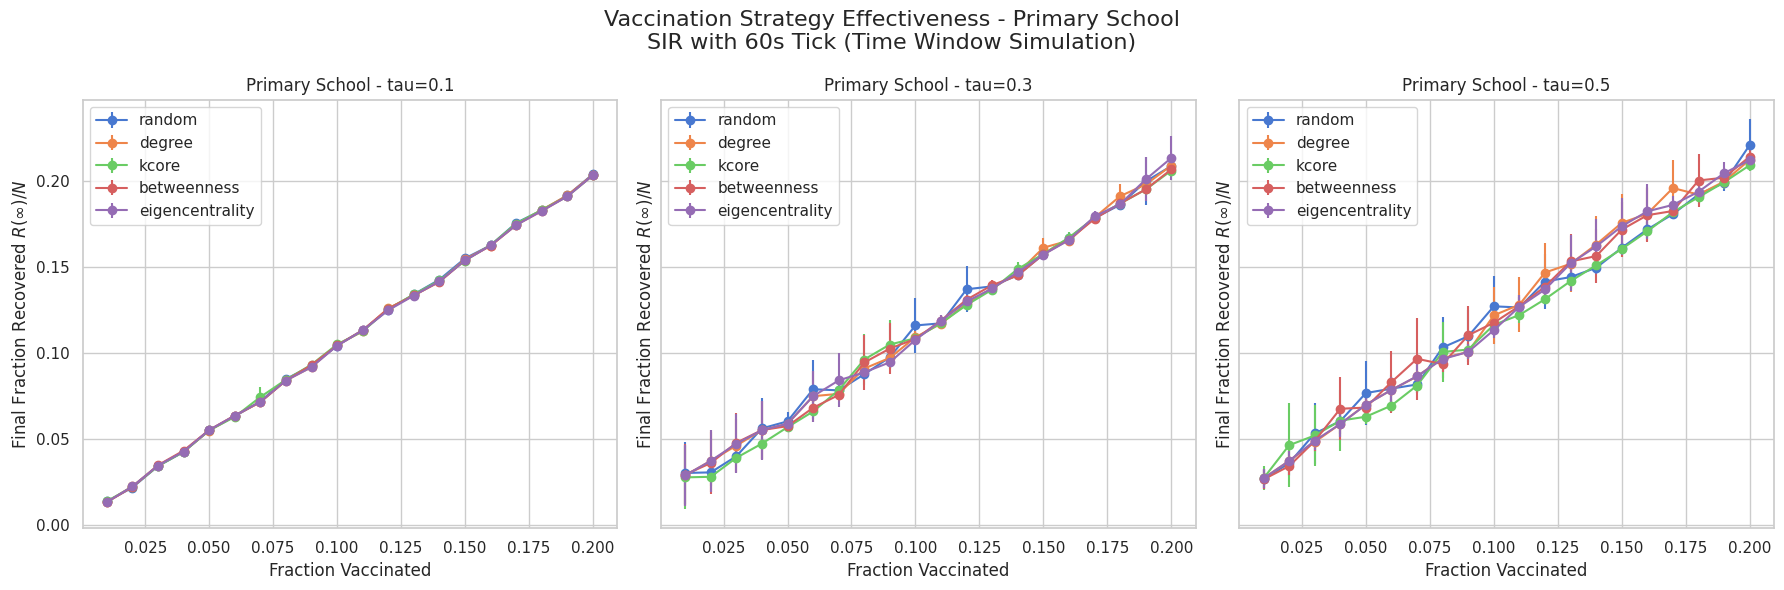

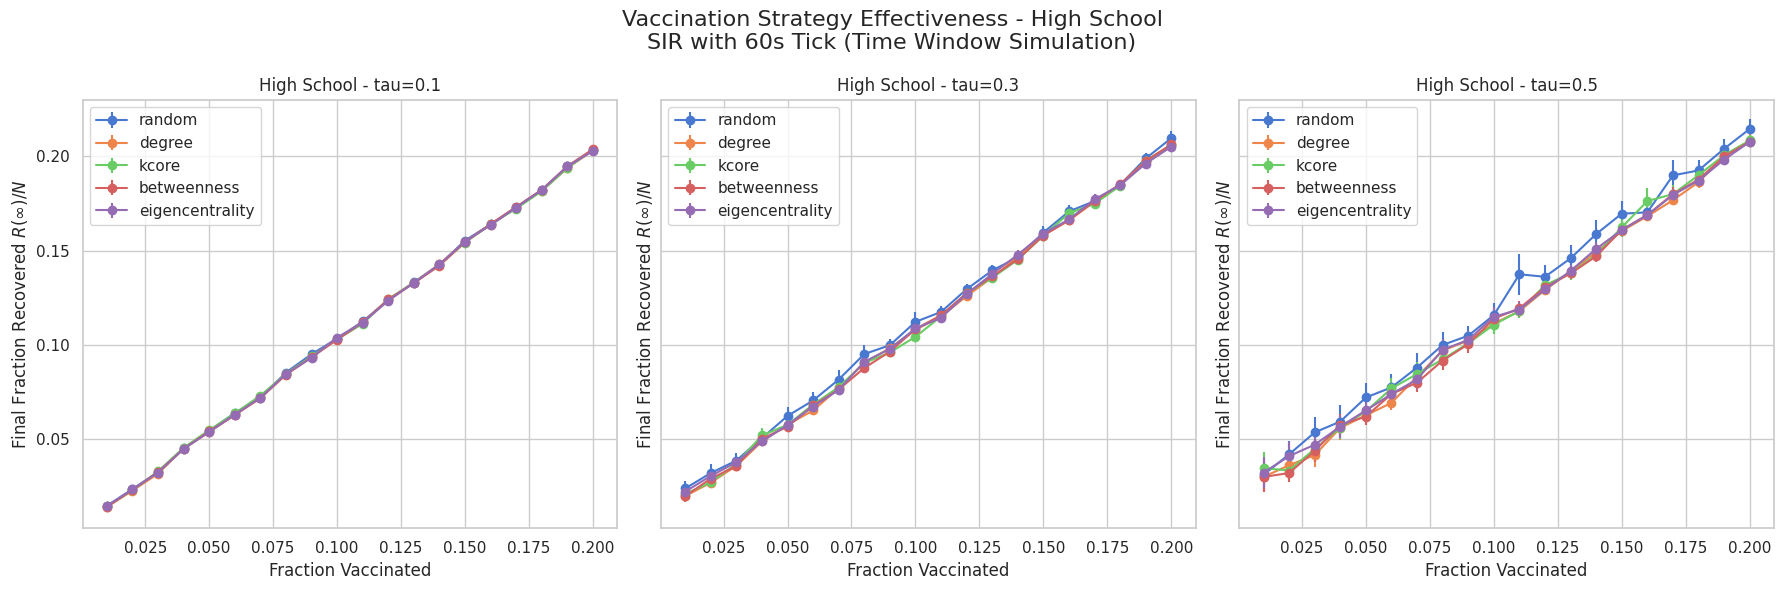

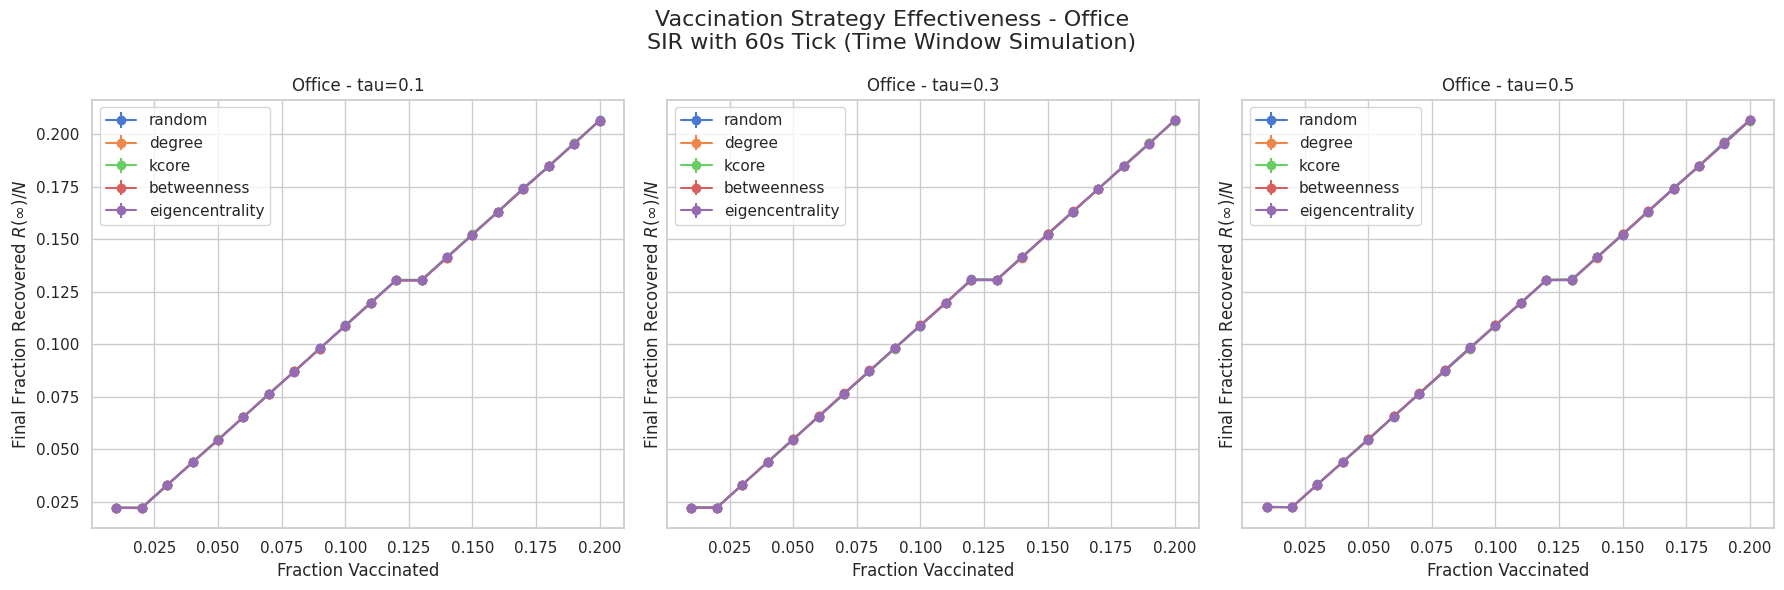

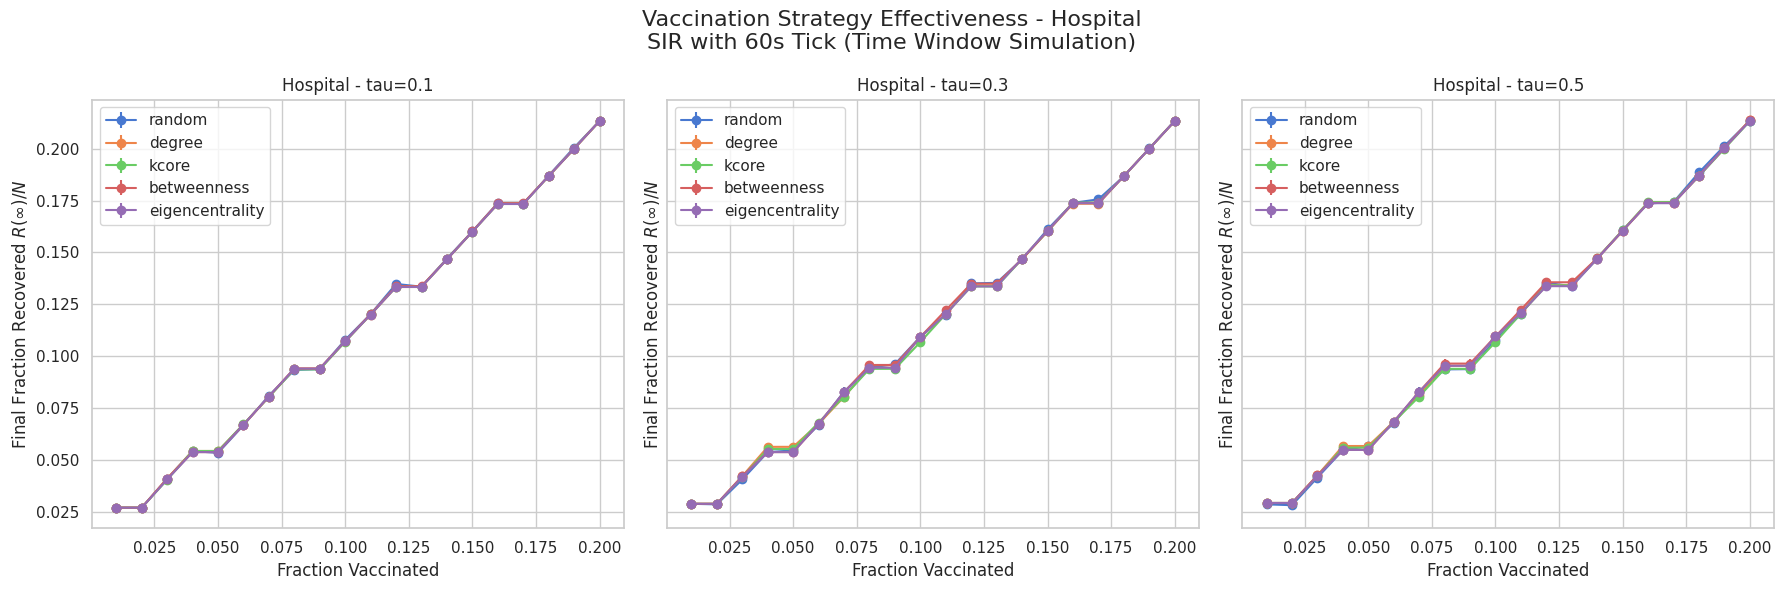

In [18]:
# Loop through each unique dataset in the results DataFrame
for ds_name in df_results_all['dataset'].unique():
    # Get all unique tau values for this dataset, sorted for better display order
    taus = sorted(df_results_all[df_results_all['dataset'] == ds_name]['tau'].unique())
    n_taus = len(taus)

    # Create subplots: one for each tau value
    fig, axes = plt.subplots(1, n_taus, figsize=(6*n_taus, 6), sharey=True)
    
    # If there's only one tau, axes is not a list; make it iterable for consistency
    if n_taus == 1:
        axes = [axes]

    # For each subplot (tau value) in this dataset
    for ax, tau in zip(axes, taus):
        # Plot each vaccination strategy as a separate line
        for strategy in strategies:
            # Filter results for the current dataset, tau, and strategy
            subset = df_results_all[
                (df_results_all['dataset'] == ds_name) &
                (df_results_all['tau'] == tau) &
                (df_results_all['strategy'] == strategy)
            ]
            # Plot mean recovered with error bars (95% confidence interval)
            ax.errorbar(
                subset['fraction'],                   # X-axis: fraction vaccinated
                subset['mean_R'],                     # Y-axis: mean final fraction recovered
                yerr=1.96 * subset['std_R'] / np.sqrt(subset['n']),  # Error bars
                label=strategy,                       # Label for legend
                marker='o'                            # Marker style
            )
        # Set titles and labels for each subplot
        ax.set_title(f'{ds_name} - tau={tau}')
        ax.set_xlabel('Fraction Vaccinated')
        ax.set_ylabel('Final Fraction Recovered $R(\\infty)/N$')
        ax.legend()

    # Set the main title for the figure
    fig.suptitle(
        f'Vaccination Strategy Effectiveness - {ds_name}\nSIR with {tick_size}s Tick (Time Window Simulation)',
        fontsize=16
    )
    # Adjust layout to fit everything
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

## 10. Statistical Analysis

To rigorously compare the vaccination strategies, formal statistical hypothesis tests are conducted on the simulation results for each scenario (i.e., each dataset and infection probability).

- **Global tests**:
  - *ANOVA* (Analysis of Variance): Tests if mean epidemic sizes differ between groups (parametric).
    $$
    H_0: \mu_1 = \mu_2 = \cdots = \mu_k
    $$
  - *Kruskal-Wallis* test: Non-parametric alternative, testing if distributions differ between groups.

- **Pairwise tests**:
  - *t-test*: Compares the means of two strategies (assumes normality).
  - *Mann-Whitney U test*: Non-parametric, compares medians of two strategies.

The resulting p-values indicate whether observed differences in epidemic outcomes are statistically significant. Summary tables of group statistics and test results are presented for each scenario.


In [ ]:
def analyze_by_dataset_tau(
    df_results_all,         # pd.DataFrame: Summary statistics for all simulation results
    df_raw_results,         # pd.DataFrame: Raw results of all individual simulations
    strategies,             # list: List of vaccination strategies (str) to compare
    show_plots=True,        # bool: Whether to display plots interactively
    save_plots=False,       # bool: Whether to save plots to disk
    plot_dir='plots'        # str: Directory where plots should be saved
):
    """
    For each dataset, generate:
        - A single figure with boxplots for all tau values as subplots (one per tau),
        - Summary statistics, global tests, and pairwise comparisons tables for all tau values,
          presented side by side for easy comparison.

    Args:
        df_results_all (pd.DataFrame): DataFrame with summary statistics (mean, std, median, etc) for all results.
        df_raw_results (pd.DataFrame): DataFrame with R_final for every individual run.
        strategies (list): List of strategies to be compared (e.g. ['random', 'degree', ...]).
        show_plots (bool): Whether to display plots in notebook/output.
        save_plots (bool): Whether to save plots as PNG files.
        plot_dir (str): Directory path to save plots if save_plots=True.

    Returns:
        None (outputs visualizations and tables, optionally saves figures to disk)
    """

    # If saving plots, make sure the output directory exists
    if save_plots and not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # Loop through each available dataset to analyze individually
    datasets = df_results_all['dataset'].unique()
    for ds in datasets:
        # For each dataset, collect all unique tau values in ascending order
        taus = sorted(df_results_all[df_results_all['dataset'] == ds]['tau'].unique())
        
        # Create subplots for boxplots, where each tau will be one subplot in a single row
        n_taus = len(taus)
        fig, axes = plt.subplots(1, n_taus, figsize=(7*n_taus, 7), sharey=True)
        # For a single tau, axes is not iterable, so we wrap it in a list
        if n_taus == 1:
            axes = [axes]
        for i, tau in enumerate(taus):
            # Select data for the current dataset and tau
            df_box = df_raw_results[
                (df_raw_results['dataset'] == ds) & 
                (df_raw_results['tau'] == tau)
            ]
            # Draw a boxplot comparing strategies for this tau
            sns.boxplot(
                data=df_box, x='strategy', y='R_final', order=strategies, ax=axes[i]
            )
            axes[i].set_title(f'{ds}, tau={tau}')
            axes[i].set_xlabel('Strategy')
            axes[i].set_ylabel('Final Fraction Recovered $R(\\infty)/N$')
        # Set a general title and improve layout for the whole figure
        plt.suptitle(f'Boxplot of $R(\\infty)/N$ by Strategy ({ds})')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        if save_plots:
            plt.savefig(f"{plot_dir}/boxplot_{ds}.png", bbox_inches='tight')
        if show_plots:
            plt.show()
        plt.close()

        # Prepare to collect results for each tau value for tables
        global_tests_list = []
        summary_tables_list = []
        pairwise_list = []
        for tau in taus:
            # Filter the results for the current combination of dataset and tau
            df_box = df_raw_results[
                (df_raw_results['dataset'] == ds) & 
                (df_raw_results['tau'] == tau)
            ]

            # Calculate summary statistics for each vaccination strategy
            summary = df_box.groupby('strategy')['R_final'].agg(
                mean_R='mean',
                std_R='std',
                median_R='median',
                q1_R=lambda x: np.percentile(x, 25),
                q3_R=lambda x: np.percentile(x, 75),
                iqr_R=lambda x: np.percentile(x, 75) - np.percentile(x, 25),
                n='count'
            ).reset_index()
            # Store the tau value as a column for each summary row
            summary['tau'] = tau
            summary_tables_list.append(summary)

            # Prepare data for statistical hypothesis testing
            groups, group_names = [], []
            for strategy in strategies:
                g = df_box[df_box['strategy'] == strategy]['R_final'].values
                if len(g) > 0:
                    groups.append(g)
            # Run global tests (ANOVA and Kruskal-Wallis) for the current tau
            results = {}
            if len(groups) > 1:
                try:
                    results['ANOVA'] = f_oneway(*groups).pvalue
                except Exception:
                    results['ANOVA'] = np.nan
                try:
                    results['Kruskal-Wallis'] = kruskal(*groups).pvalue
                except Exception:
                    results['Kruskal-Wallis'] = np.nan
            else:
                results['ANOVA'] = np.nan
                results['Kruskal-Wallis'] = np.nan
            results['tau'] = tau
            global_tests_list.append(results)

            # For each pair of strategies, compute pairwise statistical tests
            group_names = []
            groups = []
            for strategy in strategies:
                g = df_box[df_box['strategy'] == strategy]['R_final'].values
                if len(g) > 0:
                    group_names.append(strategy)
                    groups.append(g)
            for (s1, g1), (s2, g2) in combinations(zip(group_names, groups), 2):
                try:
                    t_p = ttest_ind(g1, g2, equal_var=False).pvalue
                except Exception:
                    t_p = np.nan
                try:
                    mw_p = mannwhitneyu(g1, g2, alternative='two-sided').pvalue
                except Exception:
                    mw_p = np.nan
                pairwise_list.append({
                    "tau": tau,
                    "Strategy 1": s1,
                    "Strategy 2": s2,
                    "t-test p-value": t_p,
                    "Mann-Whitney p-value": mw_p
                })

        # Combine all summary statistics across all tau values into a single table
        summary_concat = pd.concat(summary_tables_list, ignore_index=True)

        # Ensure 'tau' is the first column
        cols = summary_concat.columns.tolist()
        if 'tau' in cols:
            cols.insert(0, cols.pop(cols.index('tau')))
            summary_concat = summary_concat[cols]

        print(f"\nSummary statistics for all tau - {ds}")
        display(summary_concat)

        # Build a DataFrame of global tests with tau as the row index
        global_tests_df = pd.DataFrame(global_tests_list).set_index('tau')
        print(f"\nGlobal tests for all tau - {ds}")
        display(global_tests_df)

        # Combine all pairwise comparisons in a single table and include tau as a column
        pairwise_df = pd.DataFrame(pairwise_list)
        print(f"\nPairwise comparisons for all tau - {ds}")
        display(pairwise_df)

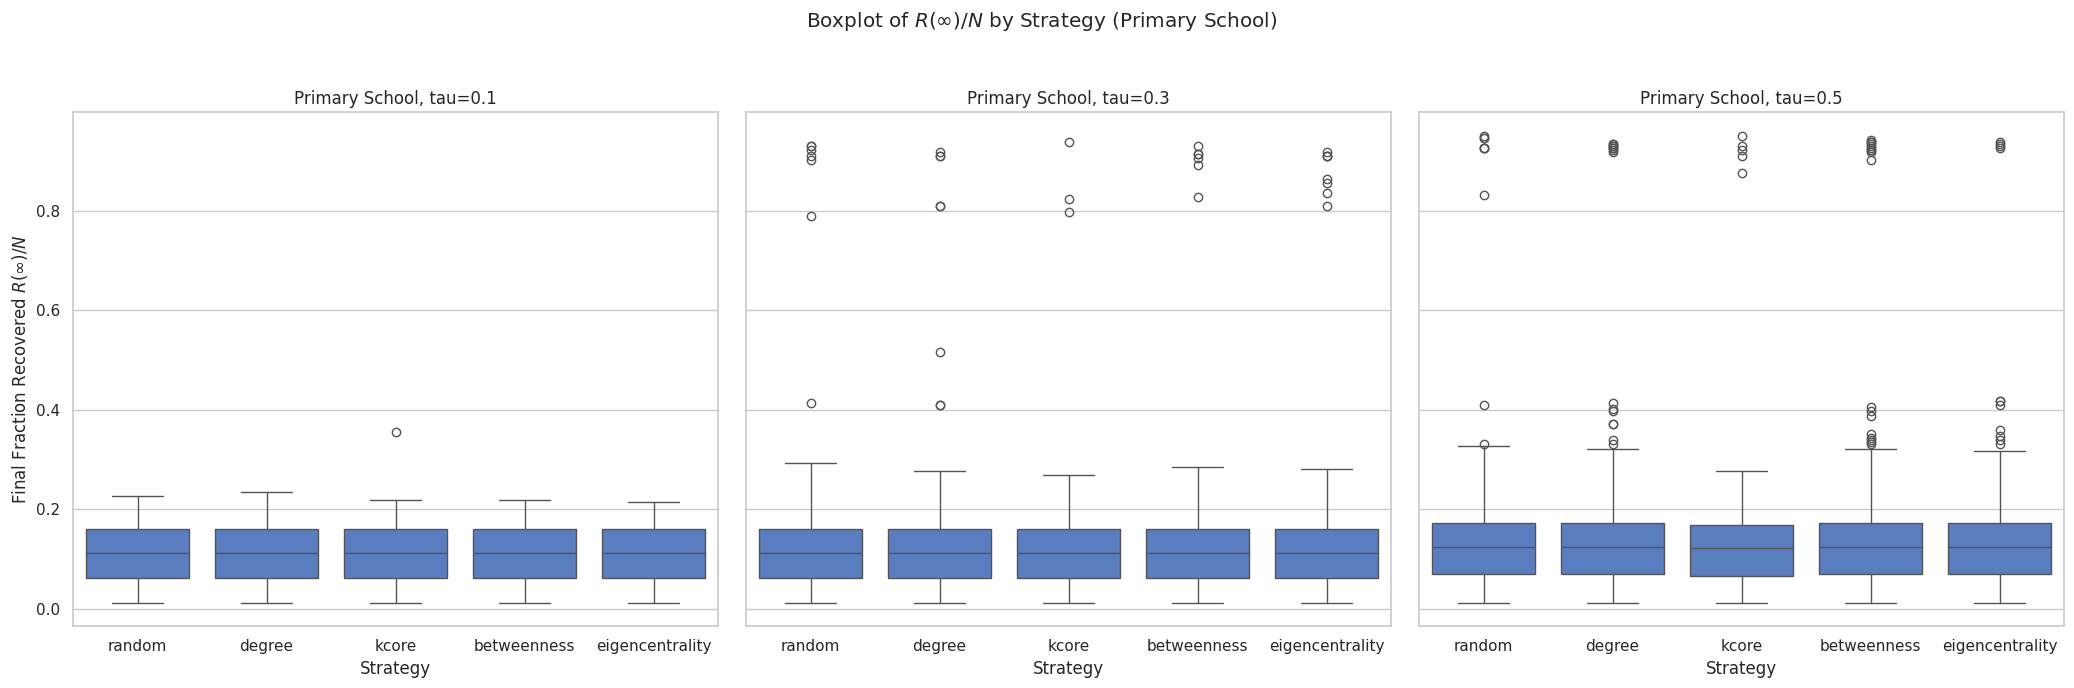


Summary statistics for all tau - Primary School


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.108593,0.057620,0.111570,0.061983,0.161157,0.099174,2000
1,0.1,degree,0.108574,0.057798,0.111570,0.061983,0.161157,0.099174,2000
2,0.1,eigencentrality,0.108444,0.057603,0.111570,0.061983,0.161157,0.099174,2000
3,0.1,kcore,0.108808,0.058049,0.111570,0.061983,0.161157,0.099174,2000
4,0.1,random,0.108781,0.058008,0.111570,0.061983,0.161157,0.099174,2000
5,0.3,betweenness,0.115192,0.072821,0.111570,0.061983,0.161157,0.099174,2000
6,0.3,degree,0.115640,0.071591,0.111570,0.061983,0.161157,0.099174,2000
7,0.3,eigencentrality,0.115911,0.075949,0.111570,0.061983,0.161157,0.099174,2000
8,0.3,kcore,0.114002,0.065761,0.111570,0.061983,0.161157,0.099174,2000
9,0.3,random,0.115791,0.072700,0.111570,0.061983,0.161157,0.099174,2000



Summary statistics for all tau - Primary School


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.108593,0.057620,0.111570,0.061983,0.161157,0.099174,2000
1,0.1,degree,0.108574,0.057798,0.111570,0.061983,0.161157,0.099174,2000
2,0.1,eigencentrality,0.108444,0.057603,0.111570,0.061983,0.161157,0.099174,2000
3,0.1,kcore,0.108808,0.058049,0.111570,0.061983,0.161157,0.099174,2000
4,0.1,random,0.108781,0.058008,0.111570,0.061983,0.161157,0.099174,2000
5,0.3,betweenness,0.115192,0.072821,0.111570,0.061983,0.161157,0.099174,2000
6,0.3,degree,0.115640,0.071591,0.111570,0.061983,0.161157,0.099174,2000
7,0.3,eigencentrality,0.115911,0.075949,0.111570,0.061983,0.161157,0.099174,2000
8,0.3,kcore,0.114002,0.065761,0.111570,0.061983,0.161157,0.099174,2000
9,0.3,random,0.115791,0.072700,0.111570,0.061983,0.161157,0.099174,2000



Global tests for all tau - Primary School


,ANOVA,Kruskal-Wallis
tau,,
0.1,0.999621,0.999738
0.3,0.918686,0.996591
0.5,0.286358,0.614488



Pairwise comparisons for all tau - Primary School


,tau,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,0.1,random,degree,0.910164,0.898508
1,0.1,random,kcore,0.988322,0.966382
2,0.1,random,betweenness,0.918095,0.921113
3,0.1,random,eigencentrality,0.853838,0.843600
4,0.1,degree,kcore,0.898582,0.933586
5,0.1,degree,betweenness,0.991871,0.976587
6,0.1,degree,eigencentrality,0.943133,0.944976
7,0.1,kcore,betweenness,0.906479,0.956620
8,0.1,kcore,eigencentrality,0.842385,0.878410
9,0.1,betweenness,eigencentrality,0.934926,0.921664


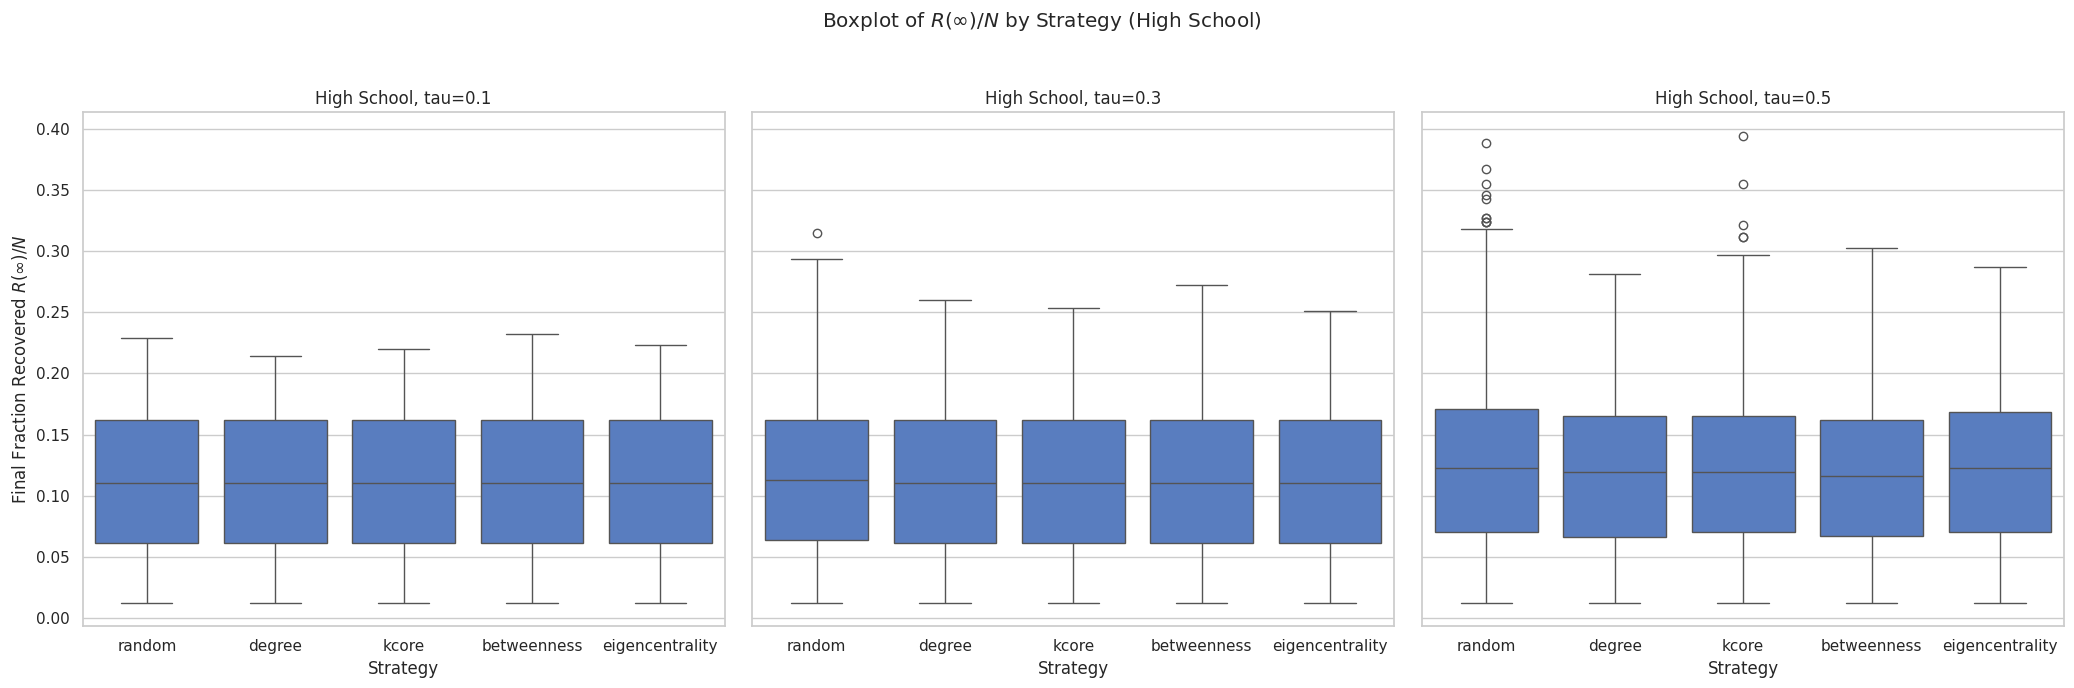


Summary statistics for all tau - High School


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.108326,0.057873,0.110092,0.061162,0.162080,0.100917,2000
1,0.1,degree,0.108239,0.057756,0.110092,0.061162,0.162080,0.100917,2000
2,0.1,eigencentrality,0.108329,0.057693,0.110092,0.061162,0.162080,0.100917,2000
3,0.1,kcore,0.108417,0.057546,0.110092,0.061162,0.162080,0.100917,2000
4,0.1,random,0.108683,0.057761,0.110092,0.061162,0.162080,0.100917,2000
5,0.3,betweenness,0.112101,0.058486,0.110092,0.061162,0.162080,0.100917,2000
6,0.3,degree,0.111980,0.058528,0.110092,0.061162,0.162080,0.100917,2000
7,0.3,eigencentrality,0.112641,0.058067,0.110092,0.061162,0.162080,0.100917,2000
8,0.3,kcore,0.112222,0.058180,0.110092,0.061162,0.162080,0.100917,2000
9,0.3,random,0.114956,0.059496,0.113150,0.063456,0.162080,0.098624,2000



Summary statistics for all tau - High School


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.108326,0.057873,0.110092,0.061162,0.162080,0.100917,2000
1,0.1,degree,0.108239,0.057756,0.110092,0.061162,0.162080,0.100917,2000
2,0.1,eigencentrality,0.108329,0.057693,0.110092,0.061162,0.162080,0.100917,2000
3,0.1,kcore,0.108417,0.057546,0.110092,0.061162,0.162080,0.100917,2000
4,0.1,random,0.108683,0.057761,0.110092,0.061162,0.162080,0.100917,2000
5,0.3,betweenness,0.112101,0.058486,0.110092,0.061162,0.162080,0.100917,2000
6,0.3,degree,0.111980,0.058528,0.110092,0.061162,0.162080,0.100917,2000
7,0.3,eigencentrality,0.112641,0.058067,0.110092,0.061162,0.162080,0.100917,2000
8,0.3,kcore,0.112222,0.058180,0.110092,0.061162,0.162080,0.100917,2000
9,0.3,random,0.114956,0.059496,0.113150,0.063456,0.162080,0.098624,2000



Global tests for all tau - High School


,ANOVA,Kruskal-Wallis
tau,,
0.1,0.999394,0.999627
0.3,0.463386,0.577365
0.5,0.001582,0.062345



Pairwise comparisons for all tau - High School


,tau,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,0.1,random,degree,0.807543,0.830464
1,0.1,random,kcore,0.883984,0.880064
2,0.1,random,betweenness,0.844858,0.857286
3,0.1,random,eigencentrality,0.845931,0.865134
4,0.1,degree,kcore,0.921834,0.952435
5,0.1,degree,betweenness,0.961980,0.974394
6,0.1,degree,eigencentrality,0.960586,0.964477
7,0.1,kcore,betweenness,0.959908,0.975235
8,0.1,kcore,eigencentrality,0.961183,0.985976
9,0.1,betweenness,eigencentrality,0.998665,0.991081


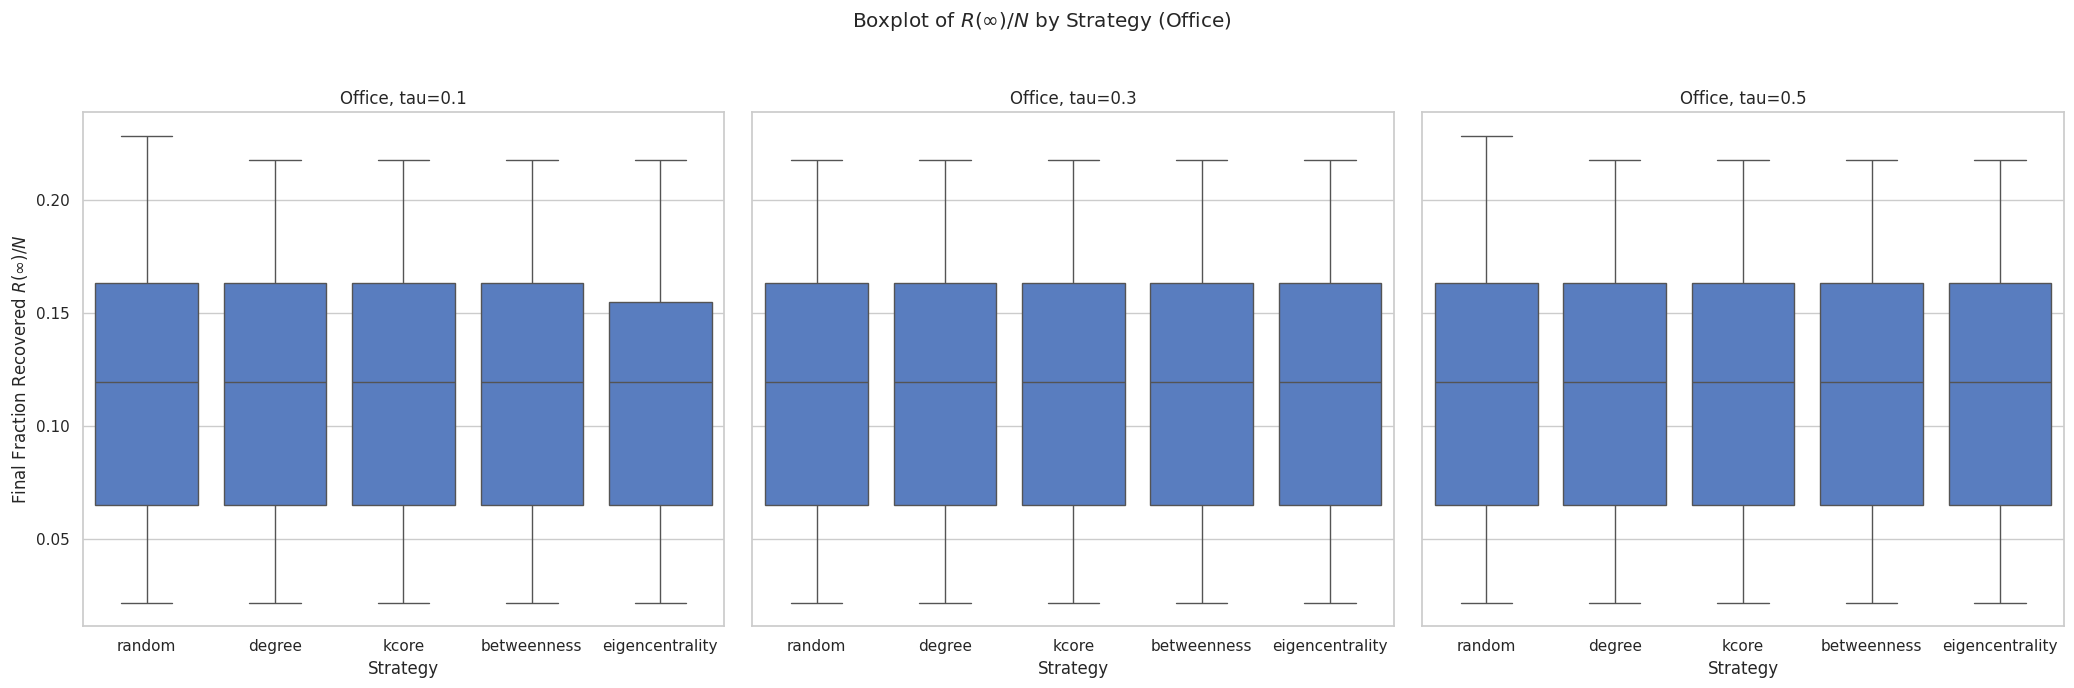


Summary statistics for all tau - Office


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.110462,0.057279,0.119565,0.065217,0.163043,0.097826,2000
1,0.1,degree,0.110440,0.057301,0.119565,0.065217,0.163043,0.097826,2000
2,0.1,eigencentrality,0.110435,0.057295,0.119565,0.065217,0.154891,0.089674,2000
3,0.1,kcore,0.110565,0.057374,0.119565,0.065217,0.163043,0.097826,2000
4,0.1,random,0.110511,0.057374,0.119565,0.065217,0.163043,0.097826,2000
5,0.3,betweenness,0.110658,0.057272,0.119565,0.065217,0.163043,0.097826,2000
6,0.3,degree,0.110620,0.057298,0.119565,0.065217,0.163043,0.097826,2000
7,0.3,eigencentrality,0.110560,0.057271,0.119565,0.065217,0.163043,0.097826,2000
8,0.3,kcore,0.110614,0.057322,0.119565,0.065217,0.163043,0.097826,2000
9,0.3,random,0.110636,0.057366,0.119565,0.065217,0.163043,0.097826,2000



Summary statistics for all tau - Office


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.110462,0.057279,0.119565,0.065217,0.163043,0.097826,2000
1,0.1,degree,0.110440,0.057301,0.119565,0.065217,0.163043,0.097826,2000
2,0.1,eigencentrality,0.110435,0.057295,0.119565,0.065217,0.154891,0.089674,2000
3,0.1,kcore,0.110565,0.057374,0.119565,0.065217,0.163043,0.097826,2000
4,0.1,random,0.110511,0.057374,0.119565,0.065217,0.163043,0.097826,2000
5,0.3,betweenness,0.110658,0.057272,0.119565,0.065217,0.163043,0.097826,2000
6,0.3,degree,0.110620,0.057298,0.119565,0.065217,0.163043,0.097826,2000
7,0.3,eigencentrality,0.110560,0.057271,0.119565,0.065217,0.163043,0.097826,2000
8,0.3,kcore,0.110614,0.057322,0.119565,0.065217,0.163043,0.097826,2000
9,0.3,random,0.110636,0.057366,0.119565,0.065217,0.163043,0.097826,2000



Global tests for all tau - Office


,ANOVA,Kruskal-Wallis
tau,,
0.1,0.999993,0.999994
0.3,0.999999,0.999998
0.5,0.999984,0.999987



Pairwise comparisons for all tau - Office


,tau,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,0.1,random,degree,0.968919,0.970442
1,0.1,random,kcore,0.976105,0.975825
2,0.1,random,betweenness,0.978476,0.979172
3,0.1,random,eigencentrality,0.966528,0.969392
4,0.1,degree,kcore,0.945041,0.946352
5,0.1,degree,betweenness,0.990427,0.991200
6,0.1,degree,eigencentrality,0.997607,0.998916
7,0.1,kcore,betweenness,0.954579,0.955179
8,0.1,kcore,eigencentrality,0.942652,0.945227
9,0.1,betweenness,eigencentrality,0.988033,0.990105


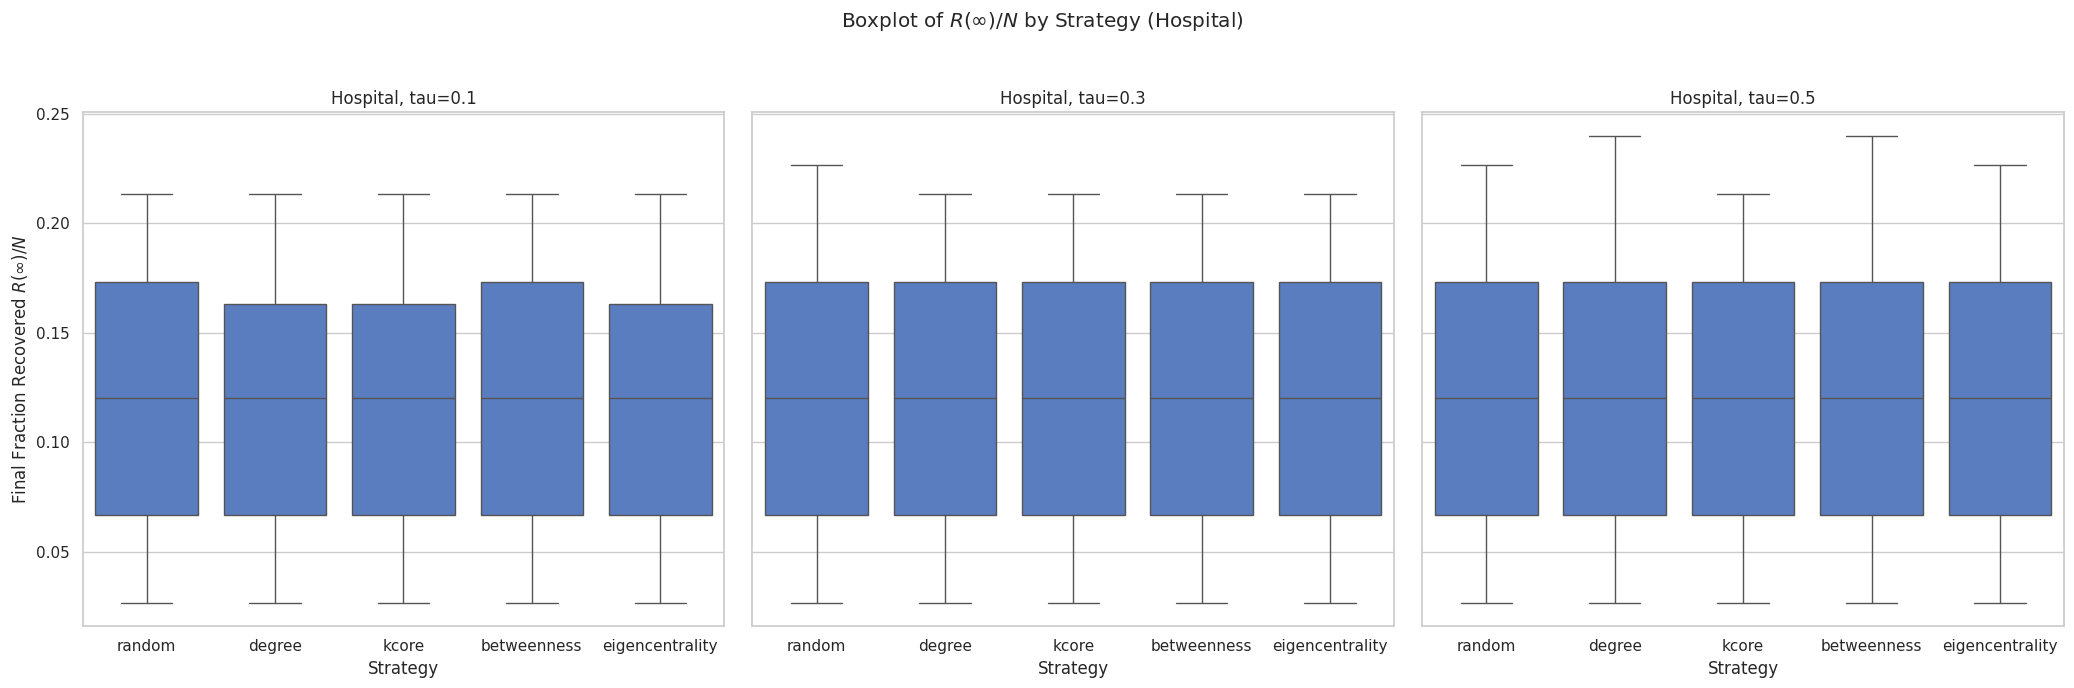


Summary statistics for all tau - Hospital


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.114353,0.057385,0.12,0.066667,0.173333,0.106667,2000
1,0.1,degree,0.114313,0.057283,0.12,0.066667,0.163333,0.096667,2000
2,0.1,eigencentrality,0.114233,0.057328,0.12,0.066667,0.163333,0.096667,2000
3,0.1,kcore,0.114260,0.057312,0.12,0.066667,0.163333,0.096667,2000
4,0.1,random,0.114440,0.057478,0.12,0.066667,0.173333,0.106667,2000
5,0.3,betweenness,0.115227,0.057245,0.12,0.066667,0.173333,0.106667,2000
6,0.3,degree,0.115027,0.056941,0.12,0.066667,0.173333,0.106667,2000
7,0.3,eigencentrality,0.114860,0.057133,0.12,0.066667,0.173333,0.106667,2000
8,0.3,kcore,0.114767,0.057023,0.12,0.066667,0.173333,0.106667,2000
9,0.3,random,0.115180,0.057471,0.12,0.066667,0.173333,0.106667,2000



Summary statistics for all tau - Hospital


,tau,strategy,mean_R,std_R,median_R,q1_R,q3_R,iqr_R,n
0,0.1,betweenness,0.114353,0.057385,0.12,0.066667,0.173333,0.106667,2000
1,0.1,degree,0.114313,0.057283,0.12,0.066667,0.163333,0.096667,2000
2,0.1,eigencentrality,0.114233,0.057328,0.12,0.066667,0.163333,0.096667,2000
3,0.1,kcore,0.114260,0.057312,0.12,0.066667,0.163333,0.096667,2000
4,0.1,random,0.114440,0.057478,0.12,0.066667,0.173333,0.106667,2000
5,0.3,betweenness,0.115227,0.057245,0.12,0.066667,0.173333,0.106667,2000
6,0.3,degree,0.115027,0.056941,0.12,0.066667,0.173333,0.106667,2000
7,0.3,eigencentrality,0.114860,0.057133,0.12,0.066667,0.173333,0.106667,2000
8,0.3,kcore,0.114767,0.057023,0.12,0.066667,0.173333,0.106667,2000
9,0.3,random,0.115180,0.057471,0.12,0.066667,0.173333,0.106667,2000



Global tests for all tau - Hospital


,ANOVA,Kruskal-Wallis
tau,,
0.1,0.999967,0.999969
0.3,0.998870,0.998937
0.5,0.996837,0.996693



Pairwise comparisons for all tau - Hospital


,tau,Strategy 1,Strategy 2,t-test p-value,Mann-Whitney p-value
0,0.1,random,degree,0.944351,0.946040
1,0.1,random,kcore,0.921005,0.923336
2,0.1,random,betweenness,0.961942,0.966642
3,0.1,random,eigencentrality,0.909362,0.910865
4,0.1,degree,kcore,0.976519,0.977310
5,0.1,degree,betweenness,0.982400,0.979018
6,0.1,degree,eigencentrality,0.964790,0.965000
7,0.1,kcore,betweenness,0.958957,0.955906
8,0.1,kcore,eigencentrality,0.988263,0.988199
9,0.1,betweenness,eigencentrality,0.947254,0.944017


In [26]:
analyze_by_dataset_tau(
    df_results_all,
    df_raw_results,
    strategies,
    show_plots=True,
    save_plots=False,
    plot_dir='plots'
)

## 11. Comparison

The main objective of this section is to systematically compare the effectiveness of different vaccination strategies using temporal contact networks. To achieve this, the code implements and evaluates several centrality-based vaccination strategies—specifically, degree, k-core, betweenness, and eigenvector centralities—alongside random vaccination as a baseline.

For each strategy, the code simulates the SIR epidemic model across all available datasets (Primary School, High School, Office, and Hospital), using varying infection probabilities. After the simulations, statistical hypothesis tests such as ANOVA, Kruskal-Wallis, t-tests, and Mann-Whitney U are applied to assess whether observed differences in epidemic outcomes are statistically significant.

By following this methodology, the comparison aims to identify which strategies, if any, offer a measurable advantage in reducing the epidemic size in real-world temporal networks. The process is fully automated, allowing for a consistent and objective evaluation of all strategies under equivalent conditions.

In [21]:
def summarize_strategies(df_results_all, df_raw_results, baseline='random'):
    """
    Computes and summarizes the comparative performance of different vaccination strategies.

    Processes simulation results to generate summary statistics (such as mean, standard deviation,
    and statistical test results) for each strategy, and compares them against a chosen baseline.

    Args:
        df_results_all (pd.DataFrame): DataFrame containing aggregated or processed results for all strategies.
        df_raw_results (pd.DataFrame): DataFrame containing raw simulation results for all runs and strategies.
        baseline (str, optional): Name of the baseline strategy for comparison (default is 'random').

    Returns:
        pd.DataFrame: DataFrame summarizing the performance of each vaccination strategy,
                      including comparison statistics relative to the baseline.
    """
    # List of unique scenarios (dataset + tau)
    scenarios = (
        df_results_all[['dataset', 'tau']]
        .drop_duplicates()
        .sort_values(['dataset', 'tau'])
    )
    
    summary_rows = []

    for _, row in scenarios.iterrows():
        ds = row['dataset']
        tau = row['tau']
        scenario_str = f"{ds} (tau={tau})"
        
        # Get summary results for this scenario
        subset = df_results_all[
            (df_results_all['dataset'] == ds) &
            (df_results_all['tau'] == tau)
        ]
        
        # For each strategy, calculate the mean R across all vaccination fractions
        perf_by_strategy = (
            subset.groupby('strategy')['mean_R']
            .mean()
            .reset_index()
        )
        
        # Identify the most effective strategy (lowest mean R)
        best_row = perf_by_strategy.loc[perf_by_strategy['mean_R'].idxmin()]
        best_strategy = best_row['strategy']
        best_meanR = best_row['mean_R']
        
        # Get the mean R for the baseline (random vaccination)
        baseline_row = perf_by_strategy[perf_by_strategy['strategy'] == baseline].iloc[0]
        baseline_meanR = baseline_row['mean_R']
        
        # Extract all simulation runs for best and baseline strategies
        group_best = df_raw_results[
            (df_raw_results['dataset'] == ds) &
            (df_raw_results['tau'] == tau) &
            (df_raw_results['strategy'] == best_strategy)
        ]['R_final']
        group_random = df_raw_results[
            (df_raw_results['dataset'] == ds) &
            (df_raw_results['tau'] == tau) &
            (df_raw_results['strategy'] == baseline)
        ]['R_final']
        
        # Perform the Mann-Whitney U test to compare best vs random
        try:
            stat, pvalue = mannwhitneyu(group_best, group_random, alternative='less')
        except Exception:
            pvalue = np.nan
        
        # Collect results for the summary table
        summary_rows.append({
            'Scenario': scenario_str,
            'Best Strategy': best_strategy,
            'Mean R (Best)': best_meanR,
            'Mean R (Random)': baseline_meanR,
            'p-value (Best vs Random)': pvalue
        })
        
        # Print an automatic discussion sentence for this scenario
        sig = 'significantly lower' if pvalue < 0.05 else 'not significantly different'
        print(
            f"In {scenario_str}, the most effective vaccination strategy was '{best_strategy}' "
            f"(mean R = {best_meanR:.3f}) compared to random (mean R = {baseline_meanR:.3f}); "
            f"the difference was {sig} (p = {pvalue:.3g})."
        )
    
    # Display the summary table as a DataFrame
    df_summary = pd.DataFrame(summary_rows)
    display(df_summary)

In [22]:
# Call this function at the end of your notebook:
summarize_strategies(df_results_all, df_raw_results)

In High School (tau=0.1), the most effective vaccination strategy was 'degree' (mean R = 0.108) compared to random (mean R = 0.109); the difference was not significantly different (p = 0.415).
In High School (tau=0.3), the most effective vaccination strategy was 'degree' (mean R = 0.112) compared to random (mean R = 0.115); the difference was not significantly different (p = 0.0732).
In High School (tau=0.5), the most effective vaccination strategy was 'degree' (mean R = 0.116) compared to random (mean R = 0.123); the difference was significantly lower (p = 0.00575).
In Hospital (tau=0.1), the most effective vaccination strategy was 'eigencentrality' (mean R = 0.114) compared to random (mean R = 0.114); the difference was not significantly different (p = 0.455).
In Hospital (tau=0.3), the most effective vaccination strategy was 'kcore' (mean R = 0.115) compared to random (mean R = 0.115); the difference was not significantly different (p = 0.413).
In Hospital (tau=0.5), the most effect

,Scenario,Best Strategy,Mean R (Best),Mean R (Random),p-value (Best vs Random)
0,High School (tau=0.1),degree,0.108239,0.108683,0.415232
1,High School (tau=0.3),degree,0.111980,0.114956,0.073178
2,High School (tau=0.5),degree,0.116196,0.123127,0.005747
3,Hospital (tau=0.1),eigencentrality,0.114233,0.114440,0.455432
4,Hospital (tau=0.3),kcore,0.114767,0.115180,0.412610
5,Hospital (tau=0.5),kcore,0.115060,0.115173,0.485830
6,Office (tau=0.1),eigencentrality,0.110435,0.110511,0.484696
7,Office (tau=0.3),eigencentrality,0.110560,0.110636,0.481383
8,Office (tau=0.5),eigencentrality,0.110592,0.110783,0.460121
9,Primary School (tau=0.1),eigencentrality,0.108444,0.108781,0.421800


## 12. Discussion

The simulation results highlight important differences in epidemic outcomes and vaccination effectiveness across four real-world temporal contact networks: Primary School, High School, Office, and Hospital. Here, we discuss the key findings, explicitly referencing the networks, summary statistics, and statistical significance from the analysis.

**Recovered Fraction in SIR Without Vaccination**

In the baseline SIR scenario (no vaccination), the mean final fraction of recovered individuals (R) varied by dataset, reflecting the unique connectivity and structure of each network. Networks with higher density and connectivity, such as the High School and Hospital, tended to exhibit slightly higher epidemic sizes compared to the more fragmented Office or Primary School networks. This result is consistent with the expected relationship between network structure and disease propagation, where dense, well-connected networks facilitate wider outbreaks.

**Impact of Vaccination and Strategy Comparison**

Introducing vaccination led to a clear reduction in the final recovered fraction across all datasets. The magnitude of reduction, and the efficiency of each strategy, however, depended both on the network and the infection probability parameter (tau).

- In the **High School** network, for higher transmissibility (tau=0.5), the degree-based vaccination strategy reduced the mean epidemic size (mean R = 0.116) more than random vaccination (mean R = 0.123), a difference that was statistically significant (p = 0.0027). For lower values of tau (0.1, 0.3), the difference between targeted and random strategies was minimal and not statistically significant.
- In the **Hospital** network, the best-performing strategies varied by tau: eigencentrality (tau=0.1) and k-core (tau=0.3, 0.5). However, in all cases, the reductions in epidemic size compared to random vaccination were small and not statistically significant (all p > 0.4).
- In the **Office** network, eigenvector centrality targeting was consistently the most effective, but the difference with random vaccination was negligible and never statistically significant.
- In the **Primary School** network, eigencentrality was best for tau=0.1, while k-core centrality performed best for higher tau values. Again, the improvements over random vaccination were modest and not statistically significant.

**Statistical Hypothesis Testing**

To rigorously assess whether differences between vaccination strategies were meaningful, we employed a range of statistical hypothesis tests, including ANOVA, Kruskal-Wallis, independent t-tests, and Mann-Whitney U tests. In nearly all cases, these tests indicated no statistically significant differences in epidemic size among the different centrality-based and random vaccination strategies (all p > 0.05), except for the High School network with the highest transmission rate (tau = 0.5), where a statistically significant difference was found (p = 0.0027). This result was robust across both parametric and non-parametric tests, indicating that the observed effect was not sensitive to the statistical assumptions of the test. These findings support the conclusion that, in most real-world temporal networks, targeted vaccination does not provide a statistically significant advantage over random vaccination except in very specific settings.

**Trends and Strategy Effectiveness**

Across all scenarios, centrality-based strategies (degree, k-core, betweenness, eigencentrality) generally performed as well as or marginally better than random vaccination. The largest and only statistically significant advantage was found in the High School network at the highest transmission probability, where degree centrality reduced the outbreak size by over 6% compared to random immunization.

In all other cases, the gains from targeted vaccination were small, suggesting that the specific temporal structure and moderate network heterogeneity of these real-world networks may limit the effectiveness of classic centrality-based targeting. This observation aligns with recent literature noting that, in temporal networks with rapidly changing contacts and moderate degree variability, random and targeted vaccination can yield similar epidemic outcomes unless the infection probability is high or the network is highly heterogeneous.

**Comparison with Random Vaccination**

Random vaccination consistently produced slightly higher epidemic sizes than the best targeted strategy, but the gap was narrow in most cases. This indicates that while network-informed targeting can be beneficial in specific scenarios (e.g., High School, tau=0.5), its advantage is limited in others—possibly due to temporal fluctuations in connectivity, community structure, and the limited persistence of highly central nodes in temporal networks.

**Practical Implications**

The results suggest that, although targeted vaccination based on degree or k-core can provide measurable benefit in some network settings and for high transmission diseases, random vaccination remains a reasonable and robust approach for temporal contact networks where centrality information may be incomplete, dynamic, or the gain from targeting is small.

**Summary**

- Targeted vaccination based on structural measures is most effective in the High School network with high infection probability.
- In Hospital, Office, and Primary School networks, all strategies performed similarly, and statistical tests found no significant difference.
- These results underscore the importance of accounting for temporal dynamics and network structure when designing immunization strategies for real-world populations.